<a href="https://colab.research.google.com/github/Danafr00/mileapp_test/blob/main/MileApp_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Delivery Analysis

##Business Understanding

In a world where anything short of one-day deliveries or same-day service calls seems unacceptable, logistics businesses of all sizes are flocking to route optimization solutions to increase the efficiency of their operations. Route optimization helps logistics transportation companies increase their top and bottom line by increasing operational efficiencies, minimizing expenses, and better serving customers, so it's well worth incorporating into the business. Delivery routing analysis is needed to find out the most important aspects for optimization of existing operational routes.

The purpose of this analysis is to find out the most important branch and what data most affects the time of delivery of goods.

##Analytic Approach

After reading the data, I tried to make an analysis of the delivery time for each branch. The data obtained at this time is in the form of branch origin, branch destination, and location of goods receipt. Based on this, this analysis is carried out by assuming that each task shows the following flow of delivery:
branch origin -> branch destination -> task location done

Assumptions used:
1. The time for creating a task and completing a task is the time required for delivery from the destination branch to the receiver's location
2. The location of the branch destination is not known with certainty, so the latitude and longitude determination is only based on the available city/district after the 3-letter city code has been changed. The value given depends on the data obtained from the nominatim website

For this project I will be using the libraries for data manipulation (Pandas, Numpy), data visualization (Matplotlib, Seaborn), machine learning (Scikit-learn, XGBoost) and some statistics to get some insight and the trend of the data. For the data visualization, I will fetch all data to BigQuery and visualize it on Google Data Studio.

##Data Understanding

In [2]:
#Install the library
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.9 MB/s eta 0:00:00


In [3]:
#Import the libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import matplotlib.pyplot as plt

from urllib.request import urlopen
import json
import requests
import urllib.parse
import geopy
import geopy.distance
import pyvis.network as net
import networkx as nx
from IPython.display import display, HTML
from geopy.geocoders import Nominatim

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from lightgbm import LGBMRegressor
from sklearn import tree, model_selection
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq


In [4]:
# store the URL in url to read the data
url = "https://raw.githubusercontent.com/indrasetiadhip/data-task-sample/main/data-sample.json"
  
# store the response of URL
response = urlopen(url)
  
# storing the JSON response 
data_json = json.loads(response.read())

In [5]:
#Store the JSON into dataframe format
df = pd.json_normalize(data_json, errors='ignore')
df.head(10)

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,UserVar.branch_dest,UserVar.taskStatusLabel,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus
0,2022-11-01 20:17:26 +0700,pacifiedLion0,2022-11-01 20:46:30 +0700,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13,CGK,COLF01
1,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 12:33:48 +0700,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.3,CGK,COLF01
2,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 13:41:57 +0700,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01
3,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 18:18:19 +0700,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01
4,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 10:51:49 +0700,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,MGL,Success,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01
5,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 19:34:44 +0700,done,Delivery,67ec7d34b4f3adbf2895,110.023131,-7.706646,206610.0,True,MGL,Success,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,2.5,CGK,COLF01
6,2022-11-01 12:00:28 +0700,pacifiedLion0,2022-11-01 20:46:03 +0700,done,Delivery,2079aa99bda230940785,109.762910,-6.926608,38200.0,True,SRG,Success,"KANDEMAN,BATANG",YANG BERSANGKUTAN,D01,0.7,CGK,COLF01
7,2022-11-01 14:23:20 +0700,pacifiedLion0,2022-11-01 15:45:13 +0700,done,Delivery,b3975d6adb8e802c749b,109.729141,-6.911588,33000.0,True,SRG,Success,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,0.04,CGK,COLF01
8,2022-11-01 09:13:16 +0700,giddyCockatoo1,2022-11-01 15:39:01 +0700,done,Delivery,ea26e88eaf27edd7885b,109.780323,-7.663731,65867.0,True,MGL,Success,"BUTUH,PURWOREJO",YANG BERSANGKUTAN,D01,0.8,CGK,COLF01
9,2022-11-01 09:13:16 +0700,giddyCockatoo1,2022-11-01 15:36:44 +0700,done,Delivery,f53a4daf67534816dbd9,109.780821,-7.663288,26800.0,True,MGL,Success,"BUTUH,PURWOREJO",YANG BERSANGKUTAN,D01,0.1,CGK,COLF01


In [6]:
df.shape

(8334, 18)

In [7]:
#Check the number of unique values
df.nunique()

taskCreatedTime                  4447
taskAssignedTo                   2787
taskCompletedTime                4051
taskStatus                          2
flow                                1
taskId                           8334
taskLocationDone.lon             3664
taskLocationDone.lat             3675
cod.amount                       1585
cod.received                        2
UserVar.branch_dest                62
UserVar.taskStatusLabel             2
UserVar.receiver_city            1830
UserVar.taskDetailStatusLabel      31
UserVar.taskDetailStatus           31
UserVar.weight                    686
UserVar.branch_origin              59
UserVar.taskStatus                  2
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   taskCreatedTime                8334 non-null   object 
 1   taskAssignedTo                 8333 non-null   object 
 2   taskCompletedTime              7566 non-null   object 
 3   taskStatus                     8334 non-null   object 
 4   flow                           8334 non-null   object 
 5   taskId                         8334 non-null   object 
 6   taskLocationDone.lon           7566 non-null   float64
 7   taskLocationDone.lat           7566 non-null   float64
 8   cod.amount                     2358 non-null   float64
 9   cod.received                   2358 non-null   object 
 10  UserVar.branch_dest            8334 non-null   object 
 11  UserVar.taskStatusLabel        7572 non-null   object 
 12  UserVar.receiver_city          8282 non-null   o

In [9]:
#Check the unique number of each columns
for i in df.select_dtypes(include=['object']).columns:
    print("This is column {0}".format(i))
    print(df[i].value_counts())
    print("------------------------------------------")

This is column taskCreatedTime
2022-11-05 07:45:30 +0700    50
2022-11-07 07:13:02 +0700    44
2022-11-07 07:10:40 +0700    42
2022-11-07 07:13:03 +0700    39
2022-11-01 08:16:31 +0700    37
                             ..
2022-11-04 07:18:13 +0700     1
2022-11-04 11:06:03 +0700     1
2022-11-04 11:35:04 +0700     1
2022-11-04 12:01:51 +0700     1
2022-11-10 07:25:40 +0700     1
Name: taskCreatedTime, Length: 4447, dtype: int64
------------------------------------------
This is column taskAssignedTo
gutturalLion9     103
gloomyLlama0       83
zestyPear3         64
emptyIcecream6     57
artisticHyena7     56
                 ... 
emptyAntelope3      1
finickyCoati6       1
thriftyLion5        1
somberHeron8        1
murkyThrushe3       1
Name: taskAssignedTo, Length: 2787, dtype: int64
------------------------------------------
This is column taskCompletedTime
2022-11-07 07:14:54 +0700    83
2022-11-05 07:48:44 +0700    55
2022-11-05 07:20:19 +0700    49
2022-11-03 07:47:21 +0700    48

##Exploratory Data Analysis

<Axes: xlabel='UserVar.branch_origin', ylabel='counts'>

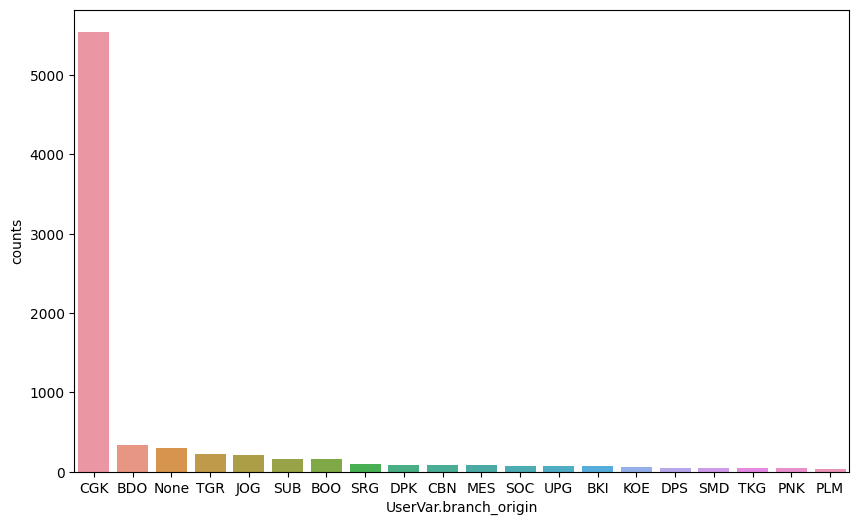

In [16]:
#Show the most used branch origin
plt.figure(figsize=(10, 6))
sns.barplot(data=df.groupby(by=['UserVar.branch_origin']).size().reset_index(name='counts').sort_values(by='counts',ascending=False).head(20),
              x='UserVar.branch_origin',
              y='counts')

<Axes: xlabel='UserVar.branch_dest', ylabel='counts'>

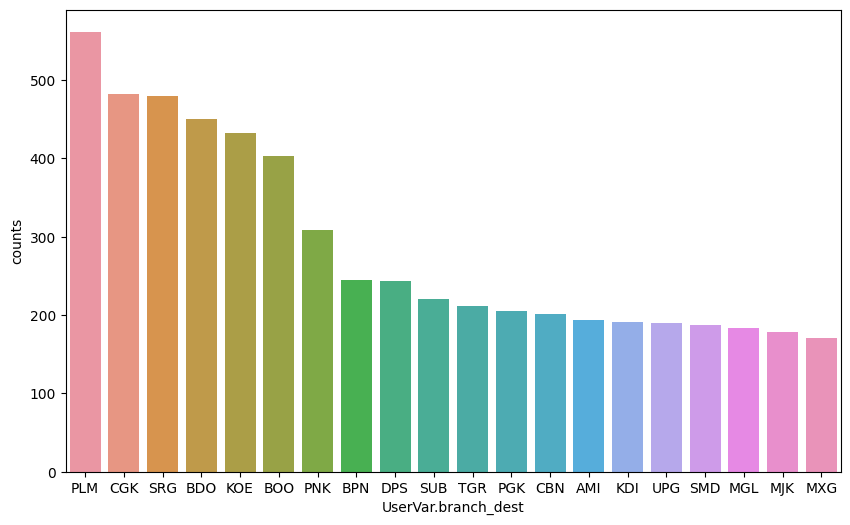

In [17]:
#Show the most used branch destination
plt.figure(figsize=(10, 6))
sns.barplot(data=df.groupby(by=['UserVar.branch_dest']).size().reset_index(name='counts').sort_values(by='counts',ascending=False).head(20),
              x='UserVar.branch_dest',
              y='counts')

<Axes: xlabel='route', ylabel='counts'>

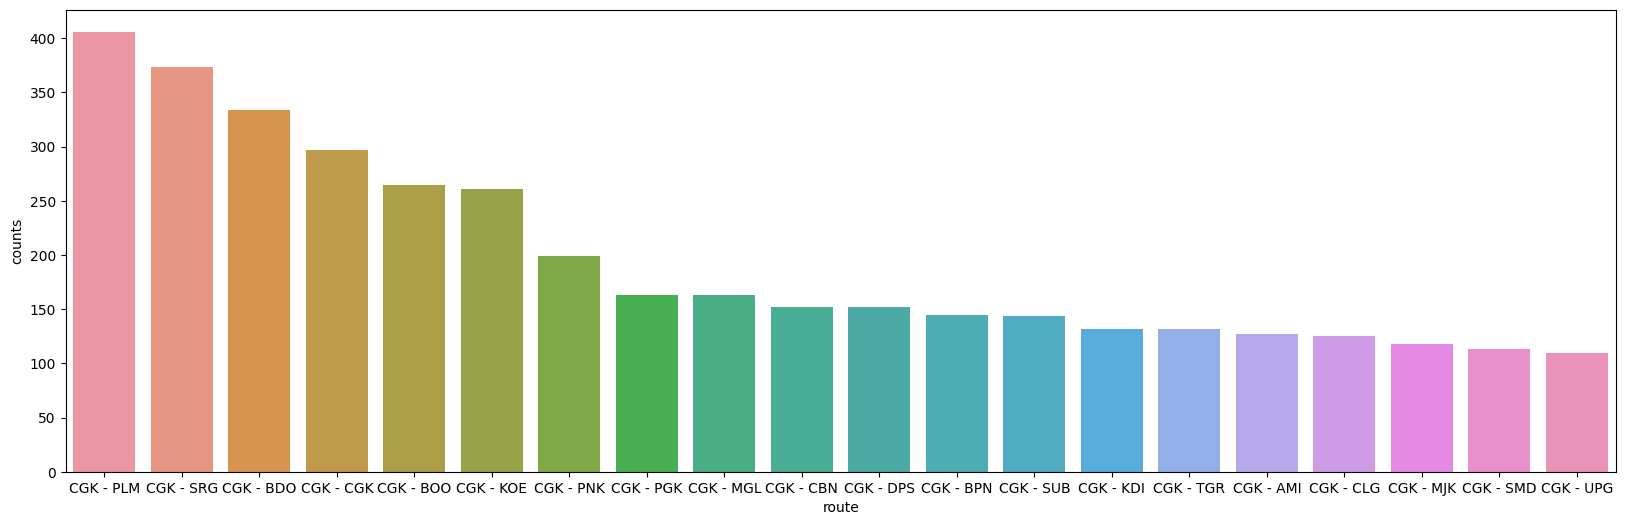

In [18]:
#Show the most used route for the delivery
df_grouped = df.groupby(by=['UserVar.branch_origin', 'UserVar.branch_dest']).size().reset_index(name='counts').sort_values(by='counts',ascending=False) 
df_grouped["route"] = df_grouped['UserVar.branch_origin'] + ' - ' + df_grouped['UserVar.branch_dest'] 
plt.figure(figsize=(20, 6))
sns.barplot(data=df_grouped.head(20),
              x='route',
              y='counts')

In [23]:
#Combine unique value of branch origin and destination to get all possible branch, the counting is based on the number of branch destination (not origin)
init_list =list(df_grouped["UserVar.branch_origin"])+list(df_grouped["UserVar.branch_dest"])
node_area = pd.Series([*set(init_list)], name='UserVar.branch_dest')
df_grouped_dest=df.groupby(by=['UserVar.branch_dest']).size().reset_index(name='counts').sort_values(by='counts',ascending=False)
result_node = pd.merge(node_area, df_grouped_dest, how='left', on='UserVar.branch_dest')
result_node.fillna(1, inplace=True)
result_node

,UserVar.branch_dest,counts
0,DPS,244.0
1,PKY,27.0
2,PLW,89.0
3,CKR,139.0
4,PWT,33.0
...,...,...
58,KDR,87.0
59,SRG,480.0
60,TGL,81.0
61,JOG,56.0


In [24]:
#Try to visualize the relationship for each branch using Graph Network
#You can filter the graph ifyou want to see the specific branch
source = df_grouped['UserVar.branch_origin']
target = df_grouped['UserVar.branch_dest']
weights = df_grouped['counts']

source_node = result_node['UserVar.branch_dest']
weights_node = result_node['counts']

g_from_data = net.Network(height='1000px',
                          width='1000px',
                          # bgcolor='white',
                          # font_color="black",
                          directed=True,
                          notebook=True, 
                          cdn_resources='in_line', 
                          filter_menu=True)


for (name,weight) in zip(source_node,weights_node):
  try:
    g_from_data.add_node(name,label=name,title=name,value=weight)
  except:
    pass
 
for (i,j,k) in zip(source,target,weights):
    try:
      g_from_data.add_edge(i,j,value=k)
    except:
      pass

g_from_data.show_buttons()
g_from_data.toggle_physics(False)
 
g_from_data.show('A_Complete_Networkx_Graph_From_DataFrame.html')
display(HTML('A_Complete_Networkx_Graph_From_DataFrame.html'))

A_Complete_Networkx_Graph_From_DataFrame.html


##Data Cleansing

Before modelling the data, we need to clean and prepare the data first, it can be:

1. Removing or filling missing data
2. Removing unneded columns
3. Removing outliers
4. Standardizing value
5. Fixing error

In [10]:
#Check the number of null values
df.isnull().sum()

taskCreatedTime                     0
taskAssignedTo                      1
taskCompletedTime                 768
taskStatus                          0
flow                                0
taskId                              0
taskLocationDone.lon              768
taskLocationDone.lat              768
cod.amount                       5976
cod.received                     5976
UserVar.branch_dest                 0
UserVar.taskStatusLabel           762
UserVar.receiver_city              52
UserVar.taskDetailStatusLabel     762
UserVar.taskDetailStatus          762
UserVar.weight                      0
UserVar.branch_origin             293
UserVar.taskStatus                762
dtype: int64

In [11]:
#Convert column types
df["UserVar.weight"]=df["UserVar.weight"].astype(np.float64)
df[['taskAssignedTo', 'cod.received', 'UserVar.branch_origin', 'UserVar.branch_dest', 'UserVar.taskDetailStatus', 'UserVar.taskStatus']] = df[['taskAssignedTo', 'cod.received', 'UserVar.branch_origin', 'UserVar.branch_dest', 'UserVar.taskDetailStatus', 'UserVar.taskStatus']].astype(str)

##Feature Engineering

In [12]:
#Standardize the value for receiver_city column
df['receiver_city_clean'] = df['UserVar.receiver_city'].str.replace(r'\bKAB\b', '', regex=True)
df['receiver_city_clean'] = df['receiver_city_clean'].str.replace(r'\bKOTA\b', '', regex=True)
df['receiver_city_clean'] = df['receiver_city_clean'].str.replace(r'.', ' ', regex=True)
df['receiver_city_clean'] = df['receiver_city_clean'].str.replace(r',', ' ', regex=True)
df['receiver_city_clean'] = df['receiver_city_clean'].str.strip(' ')

In [13]:
#Only get the unique value of cleaned receiver city column
df_city_unique = df['receiver_city_clean'].drop_duplicates()
df_city_unique.dropna(inplace=True)
df_city_unique

0            BATANG   BATANG
1        PURWODADI PURWOREJO
4          BAGELEN PURWOREJO
6            KANDEMAN BATANG
8            BUTUH PURWOREJO
                ...         
8309          CISARUA  BOGOR
8321    UJUNGBERUNG  BANDUNG
8323            MEDAN  MEDAN
8325      DENDANG MUARASABAK
8330                  BANTUL
Name: receiver_city_clean, Length: 1815, dtype: object

In [14]:
#Try the url to get the address based on latitude and longitude


# Latitude & Longitude input
lat = "-7.710998"
long = "110.003708"

url = "https://nominatim.openstreetmap.org/reverse.php?lat={0}&lon={1}&zoom=18&format=jsonv2".format(lat, long)


response = requests.get(url).json()

# Display
print(response)

{'place_id': 366434330, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 210736359, 'lat': '-7.710843649025564', 'lon': '110.00381692998457', 'place_rank': 26, 'category': 'highway', 'type': 'tertiary', 'importance': 0.10000999999999993, 'addresstype': 'road', 'name': 'Jalan Raden Ajeng Kartini', 'display_name': 'Jalan Raden Ajeng Kartini, Purworejo, Jawa Tengah, Jawa, 54113, Indonesia', 'address': {'road': 'Jalan Raden Ajeng Kartini', 'city': 'Purworejo', 'county': 'Purworejo', 'state': 'Jawa Tengah', 'ISO3166-2-lvl4': 'ID-JT', 'region': 'Jawa', 'ISO3166-2-lvl3': 'ID-JW', 'postcode': '54113', 'country': 'Indonesia', 'country_code': 'id'}, 'boundingbox': ['-7.7114963', '-7.7106112', '110.0031801', '110.0047245']}


In [15]:
#This is the converted destination city I made based on the code name
df_city = pd.read_csv('https://docs.google.com/spreadsheets/d/1TKP55H5wCEK5svEBo_JRgDDBzzR_zw00RzYhZjeq2Ow'+'/export?gid=728410653&format=csv')
df_city

,UserVar.branch_dest,dest_city_name
0,TGL,Tegal
1,DJJ,Jayapura
2,GTO,"Gorontalo, Sulawesi"
3,UPG,"Ujung Pandang, Sulawesi"
4,CKR,Cikarang
...,...,...
57,SUB,Surabaya
58,TNJ,Tanjung Pinang
59,TGR,Tangerang
60,PSR,Pasuruan


In [16]:
#Get the latitude and longitude of each destination ciy
#Actually, it might be not accurate because I dont have enough data to collect the delivery service of each trip and each city
#So here I just calculate randomly only based on the name of the city, and let the web find out the latitude and longitude of the city (not exactly the branch)
lat_city = []
long_city = []

for address in df_city['dest_city_name'].values:
  try:
    address = address
    url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

    response = requests.get(url).json()
    if response != []:
      lat_city.append(response[0]["lat"])
      long_city.append(response[0]["lon"])
    else:
      lat_city.append(np.nan)
      long_city.append(np.nan)
  except:
    print(address)

In [17]:
print(len(lat_city))
print(len(long_city))

62
62


In [18]:
#Check the result
df_city['dest_lat_city'] = np.array(lat_city)
df_city['dest_lon_city'] = np.array(long_city)
df_city.head(10)

,UserVar.branch_dest,dest_city_name,dest_lat_city,dest_lon_city
0,TGL,Tegal,-7.05644335,109.13157658590205
1,DJJ,Jayapura,-2.5387539,140.7037389
2,GTO,"Gorontalo, Sulawesi",-0.8870281,123.3838946
3,UPG,"Ujung Pandang, Sulawesi",-5.141435550000001,119.4136705800444
4,CKR,Cikarang,-6.2587148,107.145742
5,TKG,Bandar Lampung,-5.4460713,105.2643742
6,SDA,Sidoarjo,-7.45597405,112.66088771295344
7,MKQ,Merauke,-7.7925193,140.01832515
8,MDN,Madiun,-7.61188765,111.67319262808837
9,BOO,Bogor,-6.5962986,106.7972421


In [19]:
#Merge to all data
df_all = pd.merge(df, df_city, how='left', on='UserVar.branch_dest')
df_all

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,...,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,receiver_city_clean,dest_city_name,dest_lat_city,dest_lon_city
0,2022-11-01 20:17:26 +0700,pacifiedLion0,2022-11-01 20:46:30 +0700,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13.000,CGK,COLF01,BATANG BATANG,Semarang,-6.9903988,110.4229104
1,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 12:33:48 +0700,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.300,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504
2,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 13:41:57 +0700,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504
3,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 18:18:19 +0700,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504
4,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 10:51:49 +0700,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,BAGELEN PURWOREJO,Magelang,-7.51361445,110.2145132553504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,2022-11-10 09:07:12 +0700,debonairPonie1,2022-11-10 09:38:04 +0700,done,Delivery,501af4e040a742e9e878,0.000000,0.000000,NaN,nan,...,"PALMERAH ,JAKARTA BA",ATASAN/STAFF/KARYAWAN/BAWAHAN,D10,1.000,CGK,COLF01,PALMERAH JAKARTA BA,Jakarta,-6.175247,106.8270488
8330,2022-11-10 09:21:42 +0700,murkyThrushe3,2022-11-10 09:37:52 +0700,done,Delivery,5cc952d9e9f8066dbf24,110.352054,-7.892571,NaN,nan,...,KOTA BANTUL,ALAMAT TIDAK LENGKAP service/ TIDAK DIKENAL,U01,1.000,TGR,COLF02,BANTUL,Yogyakarta,-7.9778383999999996,110.36722565020224
8331,2022-11-10 09:36:44 +0700,enragedCake7,2022-11-10 09:37:55 +0700,done,Delivery,1b136b5a3c60749eb571,105.664897,-5.359063,NaN,nan,...,MARGA SEKAMPUNG KAB.,YANG BERSANGKUTAN,D01,1.440,CGK,COLF01,MARGA SEKAMPUNG,Bandar Lampung,-5.4460713,105.2643742
8332,2022-11-10 07:25:40 +0700,lyingPaella2,2022-11-10 10:37:53 +0800,done,Delivery,e92e813c8539080c922e,119.877173,-8.513305,151000.0,False,...,"KOMODO,LABUAN BAJO",PENERIMA PINDAH ALAMAT,U03,0.600,CGK,COLF02,KOMODO LABUAN BAJO,"Kupang, Timor",-10.1432432,123.6585378


In [20]:
#Here, I calculate the distance between the branch destination and task location done. It might be no accurate because of the reason before
id_list = []
distance = []

for (id, lat1, lon1, lat2, lon2) in zip(df_all['taskId'].values,
                                    df_all['taskLocationDone.lat'].values, 
                                    df_all['taskLocationDone.lon'].values,
                                    df_all['dest_lat_city'].values,
                                    df_all['dest_lon_city']):
  try:
    if (lat1!=0 or lon1!=0):
      coords_1 = (lat1, lon1)
      coords_2 = (lat2, lon2)
      distance.append(geopy.distance.geodesic(coords_1, coords_2).km)
      id_list.append(id)
    else:
      pass
    
  except:
    pass

df_distance = pd.DataFrame(list(zip(id_list, distance)), columns=['taskId', 'distance(km)'])
df_distance



,taskId,distance(km)
0,4fe3b237c832ca4841a2,73.273671
1,08a4da25256affae8446,44.768913
2,2ff0dc469826158b7684,44.087177
3,331c172c2b383f774328,31.900013
4,a9d53fa96c80baee8b23,41.379771
...,...,...
5110,abb2cc73275d23947762,9.155145
5111,4df98016923e193d39ec,18.600634
5112,5cc952d9e9f8066dbf24,9.577383
5113,1b136b5a3c60749eb571,45.420134


In [21]:
#Merge all the data
df_all = pd.merge(df_all, df_distance, how='left', on='taskId')
df_all

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,...,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,receiver_city_clean,dest_city_name,dest_lat_city,dest_lon_city,distance(km)
0,2022-11-01 20:17:26 +0700,pacifiedLion0,2022-11-01 20:46:30 +0700,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,YANG BERSANGKUTAN,D01,13.000,CGK,COLF01,BATANG BATANG,Semarang,-6.9903988,110.4229104,73.273671
1,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 12:33:48 +0700,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,YANG BERSANGKUTAN,D01,1.300,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.768913
2,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 13:41:57 +0700,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.087177
3,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 18:18:19 +0700,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,YANG BERSANGKUTAN,D01,0.625,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,31.900013
4,2022-11-01 08:41:07 +0700,peacefulTacos6,2022-11-01 10:51:49 +0700,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,YANG BERSANGKUTAN,D01,3.000,CGK,COLF01,BAGELEN PURWOREJO,Magelang,-7.51361445,110.2145132553504,41.379771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,2022-11-10 09:07:12 +0700,debonairPonie1,2022-11-10 09:38:04 +0700,done,Delivery,501af4e040a742e9e878,0.000000,0.000000,NaN,nan,...,ATASAN/STAFF/KARYAWAN/BAWAHAN,D10,1.000,CGK,COLF01,PALMERAH JAKARTA BA,Jakarta,-6.175247,106.8270488,NaN
8330,2022-11-10 09:21:42 +0700,murkyThrushe3,2022-11-10 09:37:52 +0700,done,Delivery,5cc952d9e9f8066dbf24,110.352054,-7.892571,NaN,nan,...,ALAMAT TIDAK LENGKAP service/ TIDAK DIKENAL,U01,1.000,TGR,COLF02,BANTUL,Yogyakarta,-7.9778383999999996,110.36722565020224,9.577383
8331,2022-11-10 09:36:44 +0700,enragedCake7,2022-11-10 09:37:55 +0700,done,Delivery,1b136b5a3c60749eb571,105.664897,-5.359063,NaN,nan,...,YANG BERSANGKUTAN,D01,1.440,CGK,COLF01,MARGA SEKAMPUNG,Bandar Lampung,-5.4460713,105.2643742,45.420134
8332,2022-11-10 07:25:40 +0700,lyingPaella2,2022-11-10 10:37:53 +0800,done,Delivery,e92e813c8539080c922e,119.877173,-8.513305,151000.0,False,...,PENERIMA PINDAH ALAMAT,U03,0.600,CGK,COLF02,KOMODO LABUAN BAJO,"Kupang, Timor",-10.1432432,123.6585378,452.825279


In [22]:
#Convert the columns to datetime
df_all['taskCreatedTime'] = pd.to_datetime(df_all['taskCreatedTime'], utc=True)
df_all['taskCompletedTime'] = pd.to_datetime(df_all['taskCompletedTime'], utc=True)

In [23]:
#Calculate the time diff to check the time needed to complete a task
df_all['time_diff(s)'] = (df_all['taskCompletedTime'] - df_all['taskCreatedTime']).dt.seconds

In [24]:
#Assume that the created time is the time of delivery of goods from the destination branch
df_all['average_speed(kmph)'] = df_all['distance(km)']/(df_all['time_diff(s)']/3600)

In [25]:
df_all

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,...,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,receiver_city_clean,dest_city_name,dest_lat_city,dest_lon_city,distance(km),time_diff(s),average_speed(kmph)
0,2022-11-01 13:17:26+00:00,pacifiedLion0,2022-11-01 13:46:30+00:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,13.000,CGK,COLF01,BATANG BATANG,Semarang,-6.9903988,110.4229104,73.273671,1744.0,151.252991
1,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 05:33:48+00:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,1.300,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.768913,13961.0,11.544165
2,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 06:41:57+00:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,3.000,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.087177,18050.0,8.793010
3,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 11:18:19+00:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,0.625,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,31.900013,34632.0,3.316010
4,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 03:51:49+00:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,3.000,CGK,COLF01,BAGELEN PURWOREJO,Magelang,-7.51361445,110.2145132553504,41.379771,7842.0,18.996069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8329,2022-11-10 02:07:12+00:00,debonairPonie1,2022-11-10 02:38:04+00:00,done,Delivery,501af4e040a742e9e878,0.000000,0.000000,NaN,nan,...,1.000,CGK,COLF01,PALMERAH JAKARTA BA,Jakarta,-6.175247,106.8270488,NaN,1852.0,NaN
8330,2022-11-10 02:21:42+00:00,murkyThrushe3,2022-11-10 02:37:52+00:00,done,Delivery,5cc952d9e9f8066dbf24,110.352054,-7.892571,NaN,nan,...,1.000,TGR,COLF02,BANTUL,Yogyakarta,-7.9778383999999996,110.36722565020224,9.577383,970.0,35.544927
8331,2022-11-10 02:36:44+00:00,enragedCake7,2022-11-10 02:37:55+00:00,done,Delivery,1b136b5a3c60749eb571,105.664897,-5.359063,NaN,nan,...,1.440,CGK,COLF01,MARGA SEKAMPUNG,Bandar Lampung,-5.4460713,105.2643742,45.420134,71.0,2302.992698
8332,2022-11-10 00:25:40+00:00,lyingPaella2,2022-11-10 02:37:53+00:00,done,Delivery,e92e813c8539080c922e,119.877173,-8.513305,151000.0,False,...,0.600,CGK,COLF02,KOMODO LABUAN BAJO,"Kupang, Timor",-10.1432432,123.6585378,452.825279,7933.0,205.492374


In [26]:
df_all.describe()

,taskLocationDone.lon,taskLocationDone.lat,cod.amount,UserVar.weight,distance(km),time_diff(s),average_speed(kmph)
count,7566.000000,7566.000000,2.358000e+03,8334.000000,5115.000000,7566.000000,5115.000000
mean,75.355852,-3.610514,1.911411e+05,2.448298,57.786945,4370.355802,682.579084
std,52.492016,3.647171,2.723770e+05,6.188171,92.433385,6052.779119,3387.264499
min,0.000000,-10.493658,8.370000e+02,0.000000,0.021052,15.000000,0.021074
25%,0.000000,-7.061575,6.100000e+04,1.000000,6.233397,599.750000,6.713558
50%,106.843097,-3.329263,1.533750e+05,1.000000,20.864941,2235.500000,26.372692
75%,112.182877,0.000000,2.350000e+05,1.600000,68.665146,4927.250000,175.988185
max,140.806424,5.564040,4.730000e+06,202.500000,1196.874767,47760.000000,69106.635749


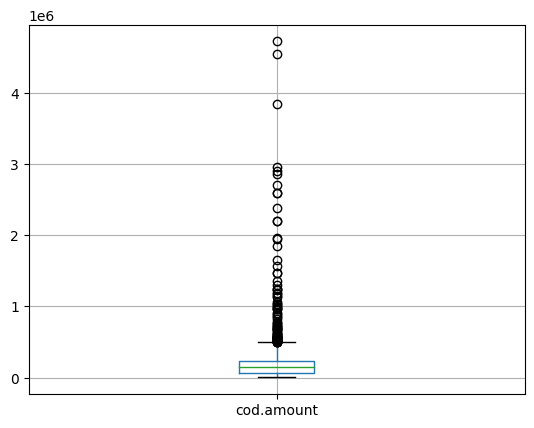

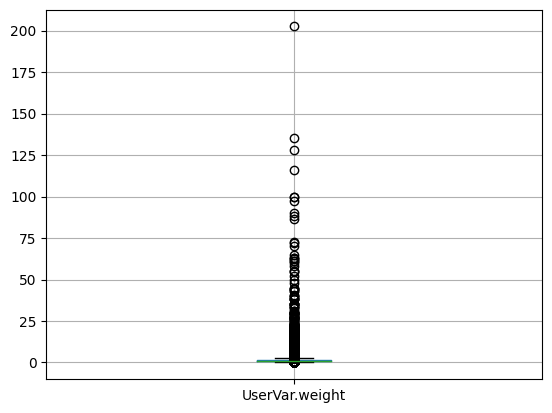

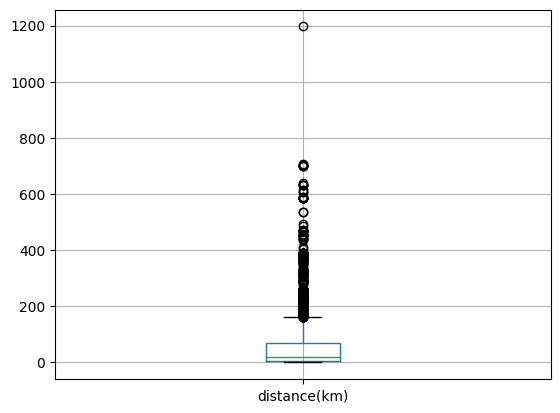

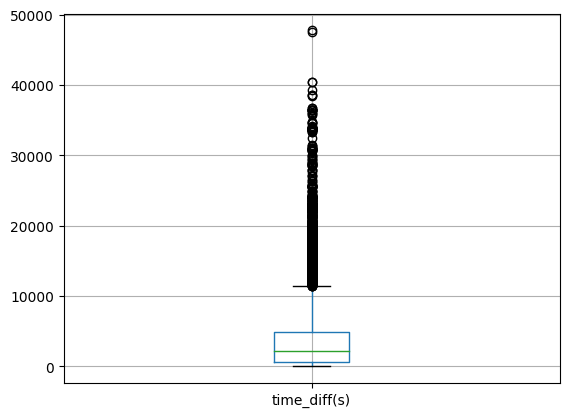

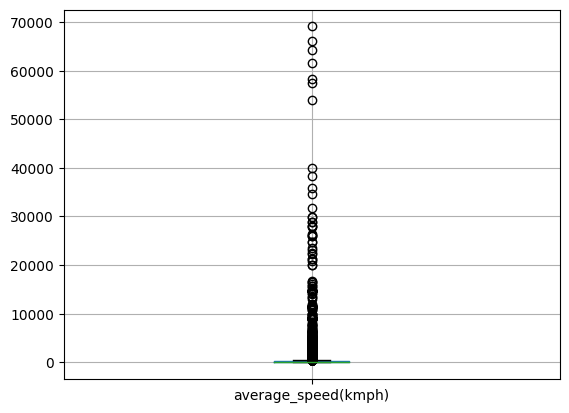

In [27]:
#Check the outliers distribution
num_columns = ["cod.amount","UserVar.weight", "distance(km)", "time_diff(s)", "average_speed(kmph)"]

for i in num_columns:
    ax=df_all.boxplot(column=i)
    plt.show()

In [28]:
#Remove outlier
for x in ["distance(km)", "time_diff(s)", "average_speed(kmph)"]:
    q75,q25 = np.percentile(df_all.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    df_all.loc[df_all[x] < min,x] = np.nan
    df_all.loc[df_all[x] > max,x] = np.nan

In [29]:
#Because there are still outliers in the average speed column, I'll just manually set the maximum average speed limit (even though 200 is still impossible, but many things are not considered here)
df_all.loc[df_all["average_speed(kmph)"] > 200,"average_speed(kmph)"] = np.nan
df_all.dropna(subset=['distance(km)', 'time_diff(s)', 'average_speed(kmph)'], inplace=True)

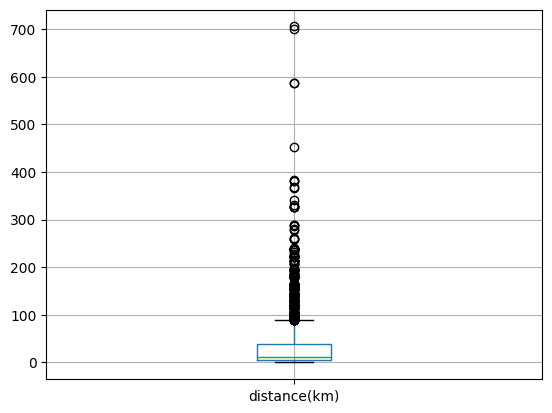

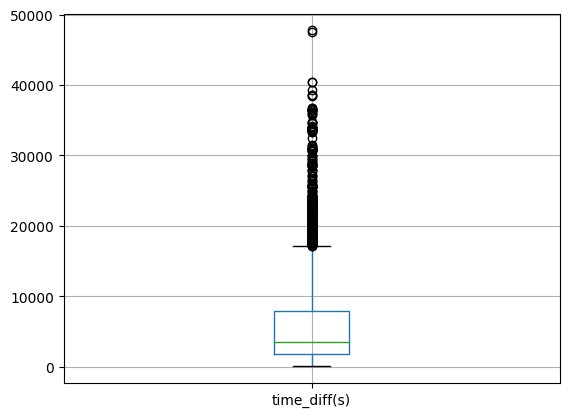

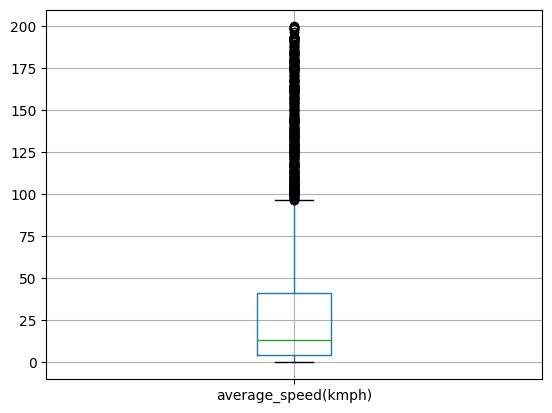

In [30]:
#Check again the distribution after removing outliers
num_columns = ["distance(km)", "time_diff(s)", "average_speed(kmph)"]

for i in num_columns:
    ax=df_all.boxplot(column=i)
    plt.show()

In [31]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3899 entries, 0 to 8330
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   taskCreatedTime                3899 non-null   datetime64[ns, UTC]
 1   taskAssignedTo                 3899 non-null   object             
 2   taskCompletedTime              3899 non-null   datetime64[ns, UTC]
 3   taskStatus                     3899 non-null   object             
 4   flow                           3899 non-null   object             
 5   taskId                         3899 non-null   object             
 6   taskLocationDone.lon           3899 non-null   float64            
 7   taskLocationDone.lat           3899 non-null   float64            
 8   cod.amount                     1027 non-null   float64            
 9   cod.received                   3899 non-null   object             
 10  UserVar.branch_dest     

In [32]:
#Remove the unknown receiver city
df_all=df_all.dropna(subset=['receiver_city_clean'])

In [59]:
#Fill the nan value of these 3 columns
df_all.loc[:, ('cod.amount')] = df_all['cod.amount'].fillna(0) #Assuming online payment used
df_all.loc[:, ('cod.received')] = df_all['cod.received'].replace('nan', 'no COD') #Assuming no COD used
df_all.loc[:, ('cod.received')] = df_all['cod.received'].fillna('No COD') #Assuming no COD used
df_all.loc[:, ('UserVar.branch_origin')] = df_all['UserVar.branch_origin'].fillna('CGK') #Assuming CGK as the origin because of the most used branch origin

<ipython-input-59-2d4865c040f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.loc[:, ('cod.amount')] = df_all['cod.amount'].fillna(0) #Assuming online payment used
<ipython-input-59-2d4865c040f8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.loc[:, ('cod.received')] = df_all['cod.received'].replace('nan', 'no COD') #Assuming no COD used
<ipython-input-59-2d4865c040f8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [60]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3880 entries, 0 to 8330
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   taskCreatedTime                3880 non-null   datetime64[ns, UTC]
 1   taskAssignedTo                 3880 non-null   object             
 2   taskCompletedTime              3880 non-null   datetime64[ns, UTC]
 3   taskStatus                     3880 non-null   object             
 4   flow                           3880 non-null   object             
 5   taskId                         3880 non-null   object             
 6   taskLocationDone.lon           3880 non-null   float64            
 7   taskLocationDone.lat           3880 non-null   float64            
 8   cod.amount                     3880 non-null   float64            
 9   cod.received                   3880 non-null   object             
 10  UserVar.branch_dest     

In [61]:
#Save the data to fetch to bigquery later
df_all.to_csv('all_data.csv')

In [62]:
df_all_filtered = df_all.copy()

##Modelling Machine Learning

In [63]:
df_all_filtered

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,...,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,receiver_city_clean,dest_city_name,dest_lat_city,dest_lon_city,distance(km),time_diff(s),average_speed(kmph)
0,2022-11-01 13:17:26+00:00,pacifiedLion0,2022-11-01 13:46:30+00:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,13.000,CGK,COLF01,BATANG BATANG,Semarang,-6.9903988,110.4229104,73.273671,1744.0,151.252991
1,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 05:33:48+00:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,1.300,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.768913,13961.0,11.544165
2,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 06:41:57+00:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,3.000,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.087177,18050.0,8.793010
3,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 11:18:19+00:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,0.625,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,31.900013,34632.0,3.316010
4,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 03:51:49+00:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,3.000,CGK,COLF01,BAGELEN PURWOREJO,Magelang,-7.51361445,110.2145132553504,41.379771,7842.0,18.996069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,2022-11-10 00:50:16+00:00,grudgingBittern7,2022-11-10 02:37:41+00:00,done,Delivery,2bf6ce01d5b6a8ac8f34,107.899584,-7.089875,0.0,no COD,...,1.000,CGK,COLF01,GARUT,"Bandung, Java",-6.9215529,107.6110212,36.920554,6445.0,20.622808
8321,2022-11-10 01:13:30+00:00,humorousPiglet8,2022-11-10 02:38:02+00:00,done,Delivery,85f340c19c6cffd3135e,107.694447,-6.924457,0.0,no COD,...,54.800,CGK,COLF01,UJUNGBERUNG BANDUNG,"Bandung, Java",-6.9215529,107.6110212,9.225213,5072.0,6.547864
8323,2022-11-10 01:56:48+00:00,giddyShads0,2022-11-10 02:37:58+00:00,done,Delivery,abb2cc73275d23947762,98.736924,3.536418,0.0,no COD,...,1.000,MES,COLF02,MEDAN MEDAN,"Medan, Sumatra",3.5896654,98.6738261,9.155145,2470.0,13.343532
8327,2022-11-10 00:27:51+00:00,dearWhiting2,2022-11-10 02:38:02+00:00,done,Delivery,4df98016923e193d39ec,101.438664,0.479580,0.0,no COD,...,1.000,CGK,COLF01,MARPOYAN DAMAI PEKA,"Pekanbaru, Sumatra",0.6111032000000001,101.54284256313278,18.600634,7811.0,8.572818


<Axes: xlabel='time_diff(s)', ylabel='distance(km)'>

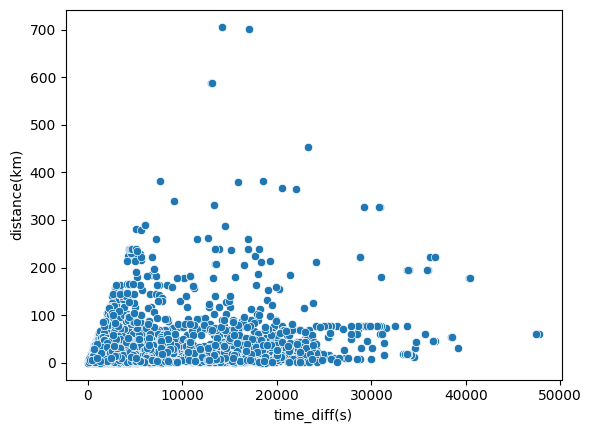

In [38]:
sns.scatterplot(data=df_all_filtered, y='distance(km)', x='time_diff(s)')

In [39]:
df_all_filtered.isnull().sum()

taskCreatedTime                  0
taskAssignedTo                   0
taskCompletedTime                0
taskStatus                       0
flow                             0
taskId                           0
taskLocationDone.lon             0
taskLocationDone.lat             0
cod.amount                       0
cod.received                     0
UserVar.branch_dest              0
UserVar.taskStatusLabel          0
UserVar.receiver_city            0
UserVar.taskDetailStatusLabel    0
UserVar.taskDetailStatus         0
UserVar.weight                   0
UserVar.branch_origin            0
UserVar.taskStatus               0
receiver_city_clean              0
dest_city_name                   0
dest_lat_city                    0
dest_lon_city                    0
distance(km)                     0
time_diff(s)                     0
average_speed(kmph)              0
dtype: int64

In [40]:
df_all_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3880 entries, 0 to 8330
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   taskCreatedTime                3880 non-null   datetime64[ns, UTC]
 1   taskAssignedTo                 3880 non-null   object             
 2   taskCompletedTime              3880 non-null   datetime64[ns, UTC]
 3   taskStatus                     3880 non-null   object             
 4   flow                           3880 non-null   object             
 5   taskId                         3880 non-null   object             
 6   taskLocationDone.lon           3880 non-null   float64            
 7   taskLocationDone.lat           3880 non-null   float64            
 8   cod.amount                     3880 non-null   float64            
 9   cod.received                   3880 non-null   object             
 10  UserVar.branch_dest     

In [41]:
#Only use the important columns
df_prepared = df_all_filtered[["taskAssignedTo", "cod.amount", "cod.received", "UserVar.branch_origin", "UserVar.branch_dest", "UserVar.taskDetailStatus", 
                 "UserVar.weight", "UserVar.taskStatus", "receiver_city_clean", "distance(km)", "time_diff(s)", "average_speed(kmph)"]]

In [42]:
df_prepared.head()

,taskAssignedTo,cod.amount,cod.received,UserVar.branch_origin,UserVar.branch_dest,UserVar.taskDetailStatus,UserVar.weight,UserVar.taskStatus,receiver_city_clean,distance(km),time_diff(s),average_speed(kmph)
0,pacifiedLion0,685000.0,True,CGK,SRG,D01,13.000,COLF01,BATANG BATANG,73.273671,1744.0,151.252991
1,peacefulTacos6,53500.0,True,CGK,MGL,D01,1.300,COLF01,PURWODADI PURWOREJO,44.768913,13961.0,11.544165
2,peacefulTacos6,179500.0,True,CGK,MGL,D01,3.000,COLF01,PURWODADI PURWOREJO,44.087177,18050.0,8.793010
3,peacefulTacos6,31815.0,True,CGK,MGL,D01,0.625,COLF01,PURWODADI PURWOREJO,31.900013,34632.0,3.316010
4,peacefulTacos6,144562.0,True,CGK,MGL,D01,3.000,COLF01,BAGELEN PURWOREJO,41.379771,7842.0,18.996069


<ipython-input-54-bc74f6db1b8d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM=df_prepared.corr()


<Axes: xlabel='cols', ylabel='time_diff(s)'>

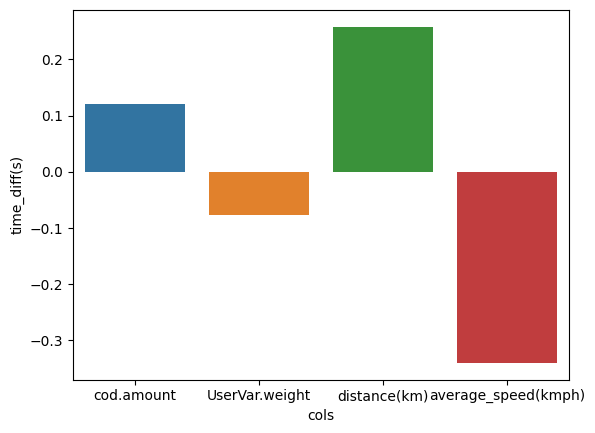

In [54]:
corrM=df_prepared.corr()
sns.barplot(data=corrM.drop('time_diff(s)').reset_index(names='cols'), x='cols', y='time_diff(s)')

### Modelling using One-Hot Encoding

In [108]:
#Perform OHE
df_dummy = pd.get_dummies(df_prepared, drop_first=True)
df_dummy.head()

,cod.amount,UserVar.weight,distance(km),time_diff(s),average_speed(kmph),taskAssignedTo_abjectCaribou1,taskAssignedTo_abjectCur0,taskAssignedTo_abjectFerret4,taskAssignedTo_abjectPepper4,taskAssignedTo_abjectSausage7,...,receiver_city_clean_WOLIO BAU-BAU,receiver_city_clean_WONGSOREJO BANYUWANG,receiver_city_clean_WONOAYU SIDOARJO,receiver_city_clean_WONOCOLO SURABAYA,receiver_city_clean_WONOGIRI WONOGIR,receiver_city_clean_WONOSARI GN KIDU,receiver_city_clean_WONOSEGORO BOYOLALI,receiver_city_clean_WONOSOBO,receiver_city_clean_WRINGINANOM GRESIK,receiver_city_clean_WUA-WUA KENDARI
0,685000.0,13.000,73.273671,1744.0,151.252991,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,53500.0,1.300,44.768913,13961.0,11.544165,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,179500.0,3.000,44.087177,18050.0,8.793010,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31815.0,0.625,31.900013,34632.0,3.316010,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,144562.0,3.000,41.379771,7842.0,18.996069,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
#Standardize the value of numeric columns
scaler = MinMaxScaler()
df_dummy[['cod.amount',	'UserVar.weight',	'distance(km)', 'average_speed(kmph)']] = scaler.fit_transform(df_dummy[['cod.amount',	'UserVar.weight',	'distance(km)', 'average_speed(kmph)']])

In [110]:
df_dummy.head()

,cod.amount,UserVar.weight,distance(km),time_diff(s),average_speed(kmph),taskAssignedTo_abjectCaribou1,taskAssignedTo_abjectCur0,taskAssignedTo_abjectFerret4,taskAssignedTo_abjectPepper4,taskAssignedTo_abjectSausage7,...,receiver_city_clean_WOLIO BAU-BAU,receiver_city_clean_WONGSOREJO BANYUWANG,receiver_city_clean_WONOAYU SIDOARJO,receiver_city_clean_WONOCOLO SURABAYA,receiver_city_clean_WONOGIRI WONOGIR,receiver_city_clean_WONOSARI GN KIDU,receiver_city_clean_WONOSEGORO BOYOLALI,receiver_city_clean_WONOSOBO,receiver_city_clean_WRINGINANOM GRESIK,receiver_city_clean_WUA-WUA KENDARI
0,0.144820,0.13000,0.103678,1744.0,0.756322,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.011311,0.01300,0.063334,13961.0,0.057628,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.037949,0.03000,0.062369,18050.0,0.043869,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.006726,0.00625,0.045120,34632.0,0.016478,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.030563,0.03000,0.058537,7842.0,0.094895,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
X = df_dummy.drop('time_diff(s)', axis=1)
y = df_dummy['time_diff(s)']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [113]:
#Try 3 different models
lgbm = LGBMRegressor()
rfc = RandomForestRegressor()
xgb = XGBRegressor()

In [114]:
models = [lgbm, rfc, xgb]
models_name = ["LGBM","Random Forest", "XGBoost"]

In [115]:
#The result and performance of 3 different models
model_fitted = []
scoring_results=[]
scorings = ["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"]

for model in models:
  score=[]
  for scoring in scorings:
    results = model_selection.cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
    score.append(results.mean())
  scoring_results.append(score)

In [116]:
#Show the model performance
model_results = pd.DataFrame(scoring_results, columns=scorings, index=models_name)
model_results


,neg_mean_absolute_error,neg_root_mean_squared_error,r2
LGBM,-555.382040,-1207.627670,0.971424
Random Forest,-509.617642,-1336.240150,0.964822
XGBoost,-597.140313,-1231.116828,0.970437


In [117]:
print(model_results["neg_root_mean_squared_error"].idxmax())

LGBM


In [118]:
#Pick only one the best model to train
model = models[models_name.index(model_results["neg_root_mean_squared_error"].idxmax())].fit(X_train, y_train)
y_pred = model.predict(X_test)

In [119]:
print("The r2 score is: ", r2_score(y_test, y_pred))
print("The mean absolute error is: ", mean_absolute_error(y_test, y_pred))
print("The root mean squared error is: ", (mean_squared_error(y_test, y_pred)**0.5))

The r2 score is:  0.9751861841207782
The mean absolute error is:  526.1110804204747
The root mean squared error is:  1220.2104476523316


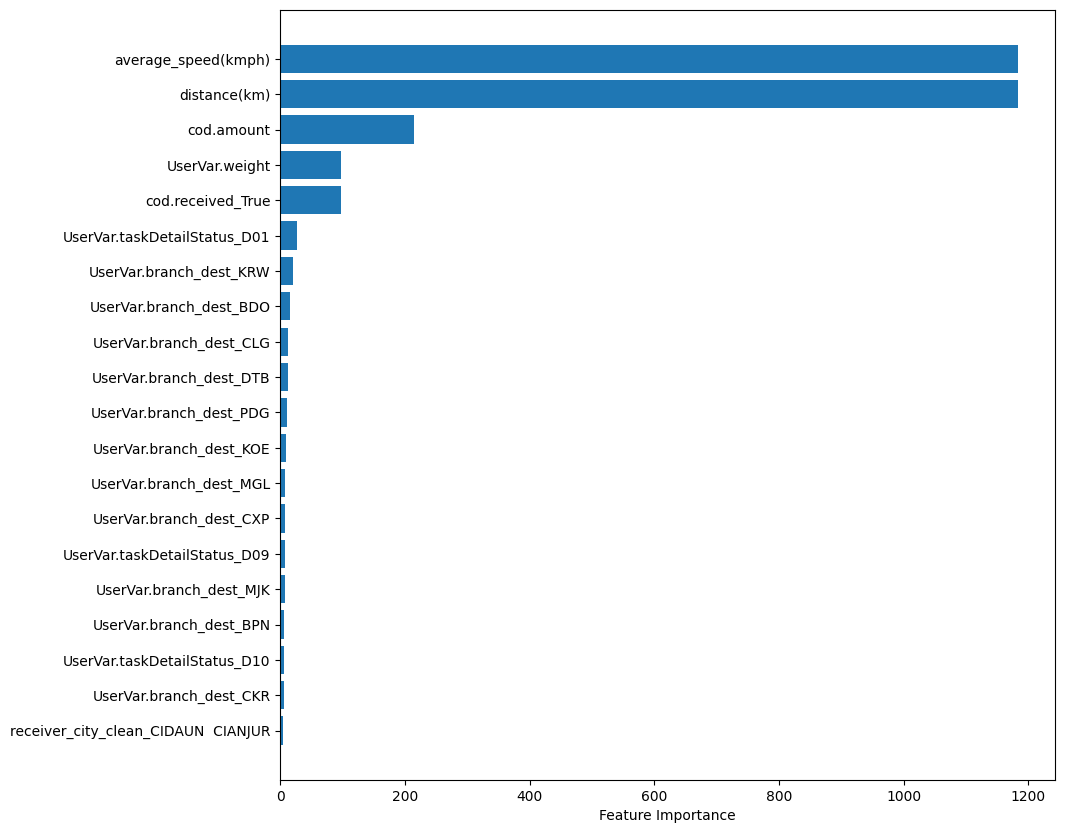

In [120]:
#Get the top 20 of most important features
sorted_idx = model.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(X.columns[sorted_idx][-20:], model.feature_importances_[sorted_idx][-20:])
plt.xlabel("Feature Importance")
plt.show()

In [121]:
test_data=y_test.copy()
test_data=test_data.reset_index()
test_data['type']="test"
test_data.drop("index", axis=1, inplace=True)
test_data.columns=["time_value", "type"]
test_data.head()

,time_value,type
0,3833.0,test
1,18745.0,test
2,937.0,test
3,1789.0,test
4,927.0,test


In [122]:
pred_data=pd.DataFrame(y_pred, columns=["time_value"])
pred_data["type"]="prediction"
pred_data

,time_value,type
0,3678.216253,prediction
1,18363.943402,prediction
2,999.304618,prediction
3,1629.824572,prediction
4,1107.870522,prediction
...,...,...
771,381.476026,prediction
772,2919.361332,prediction
773,240.486696,prediction
774,6120.796213,prediction


<Axes: xlabel='type', ylabel='time_value'>

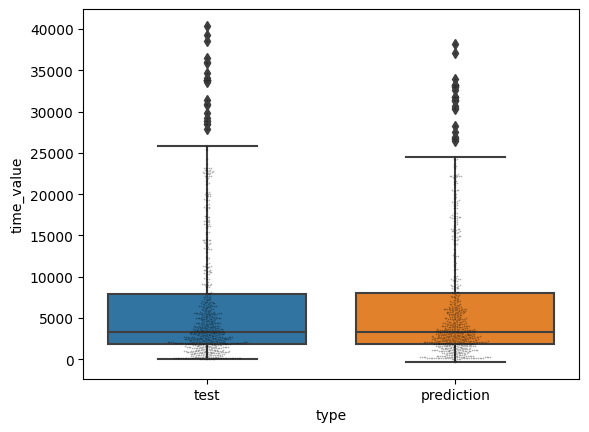

In [123]:
#Shows the difference of distributions between test and prediction value
pred_result=pd.concat([test_data, pred_data], axis=0, ignore_index=True)
sns.boxplot(x="type", y="time_value", data=pred_result, whis=3.0)
sns.swarmplot(x="type", y="time_value", data=pred_result, size=1.2, color="k", alpha=0.3)

### Modelling using Label Encoding

In [130]:
#Perform Label Encoding
from sklearn import preprocessing

df_label_encoded=df_prepared.copy()
label_encoder = preprocessing.LabelEncoder()
df_label_encoded[['taskAssignedTo', 'cod.received', 'UserVar.branch_origin', 'UserVar.branch_dest', 'UserVar.taskDetailStatus', 'UserVar.taskStatus', 'receiver_city_clean']]= df_label_encoded[['taskAssignedTo', 'cod.received', 'UserVar.branch_origin', 'UserVar.branch_dest', 'UserVar.taskDetailStatus', 'UserVar.taskStatus', 'receiver_city_clean']].apply(label_encoder.fit_transform)

In [131]:
#Standardizing the numeric value

scaler = MinMaxScaler()
df_label_encoded[['cod.amount',	'UserVar.weight',	'distance(km)', 'average_speed(kmph)']] = scaler.fit_transform(df_label_encoded[['cod.amount',	'UserVar.weight',	'distance(km)', 'average_speed(kmph)']])

In [132]:
X = df_label_encoded.drop('time_diff(s)', axis=1)
y = df_label_encoded['time_diff(s)']

In [133]:
X

,taskAssignedTo,cod.amount,cod.received,UserVar.branch_origin,UserVar.branch_dest,UserVar.taskDetailStatus,UserVar.weight,UserVar.taskStatus,receiver_city_clean,distance(km),average_speed(kmph)
0,1040,0.144820,1,10,50,3,0.13000,0,85,0.103678,0.756322
1,1073,0.011311,1,10,31,3,0.01300,0,765,0.063334,0.057628
2,1073,0.037949,1,10,31,3,0.03000,0,765,0.062369,0.043869
3,1073,0.006726,1,10,31,3,0.00625,0,765,0.045120,0.016478
4,1073,0.030563,1,10,31,3,0.03000,0,31,0.058537,0.094895
...,...,...,...,...,...,...,...,...,...,...,...
8319,670,0.000000,2,10,3,10,0.01000,0,294,0.052226,0.103031
8321,735,0.000000,2,10,3,3,0.54800,0,1046,0.013027,0.032641
8323,619,0.000000,2,27,30,14,0.01000,1,569,0.012928,0.066627
8327,384,0.000000,2,10,38,3,0.01000,0,564,0.026297,0.042768


In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [135]:
#Try 3 different models
lgbm = LGBMRegressor()
rfc = RandomForestRegressor()
xgb = XGBRegressor()

models = [lgbm, rfc, xgb]
models_name = ["LGBM","Random Forest", "XGBoost"]

In [136]:
#The result and performance of 3 different models
model_fitted = []
scoring_results=[]
scorings = ["neg_mean_absolute_error", "neg_root_mean_squared_error", "r2"]

for model in models:
  score=[]
  for scoring in scorings:
    results = model_selection.cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
    score.append(results.mean())
  scoring_results.append(score)

In [137]:
#Shows the score results
model_results = pd.DataFrame(scoring_results, columns=scorings, index=models_name)
model_results


,neg_mean_absolute_error,neg_root_mean_squared_error,r2
LGBM,-554.061547,-1184.335853,0.972474
Random Forest,-531.376747,-1289.838295,0.966317
XGBoost,-560.811494,-1187.510675,0.972266


In [138]:
#Train the best model
model = models[models_name.index(model_results["neg_root_mean_squared_error"].idxmax())].fit(X_train, y_train)
y_pred = model.predict(X_test)

print("The r2 score is: ", r2_score(y_test, y_pred))
print("The mean absolute error is: ", mean_absolute_error(y_test, y_pred))
print("The root mean squared error is: ", (mean_squared_error(y_test, y_pred)**0.5))


The r2 score is:  0.9750621764350887
The mean absolute error is:  541.6471271117142
The root mean squared error is:  1223.2556643690739


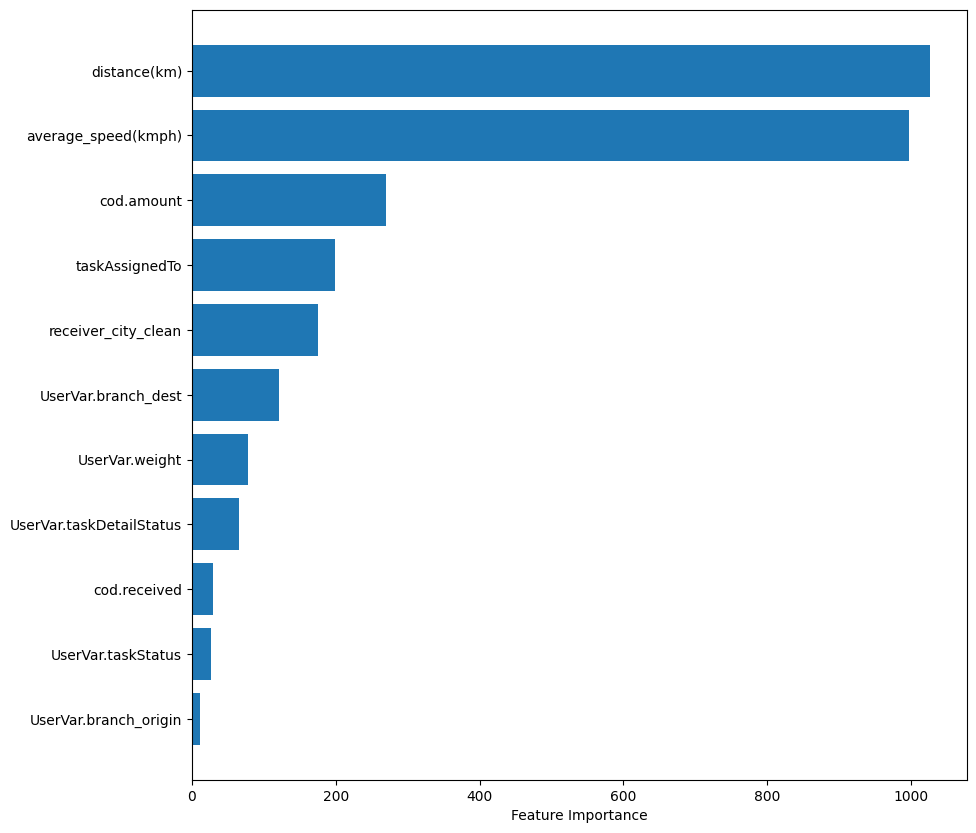

In [139]:
#Get the top 20 of most important features
sorted_idx = model.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(X.columns[sorted_idx][-20:], model.feature_importances_[sorted_idx][-20:])
plt.xlabel("Feature Importance")
plt.show()

<Axes: xlabel='type', ylabel='time_value'>

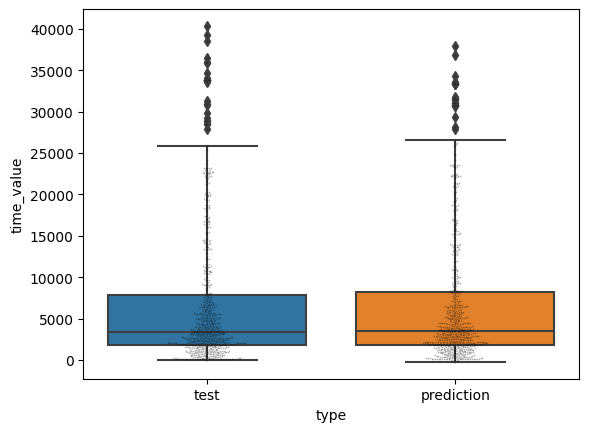

In [140]:
#Shows the difference of distributions between test and prediction value
test_data=y_test.copy()
test_data=test_data.reset_index()
test_data['type']="test"
test_data.drop("index", axis=1, inplace=True)
test_data.columns=["time_value", "type"]

pred_data=pd.DataFrame(y_pred, columns=["time_value"])
pred_data["type"]="prediction"

pred_result=pd.concat([test_data, pred_data], axis=0, ignore_index=True)
sns.boxplot(x="type", y="time_value", data=pred_result, whis=3.0)
sns.swarmplot(x="type", y="time_value", data=pred_result, size=1.2, color="k", alpha=0.3)


### Fetching Data to BigQuery

In [64]:
df_all.columns = df_all.columns.str.replace('.', '_')
df_all.columns = df_all.columns.str.replace('(', '_')
df_all.columns = df_all.columns.str.replace(')', '')

<ipython-input-64-dc63bb670e90>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_all.columns = df_all.columns.str.replace('.', '_')
<ipython-input-64-dc63bb670e90>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_all.columns = df_all.columns.str.replace('(', '_')
<ipython-input-64-dc63bb670e90>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_all.columns = df_all.columns.str.replace(')', '')


In [65]:
df_all

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone_lon,taskLocationDone_lat,cod_amount,cod_received,...,UserVar_weight,UserVar_branch_origin,UserVar_taskStatus,receiver_city_clean,dest_city_name,dest_lat_city,dest_lon_city,distance_km,time_diff_s,average_speed_kmph
0,2022-11-01 13:17:26+00:00,pacifiedLion0,2022-11-01 13:46:30+00:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,13.000,CGK,COLF01,BATANG BATANG,Semarang,-6.9903988,110.4229104,73.273671,1744.0,151.252991
1,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 05:33:48+00:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,1.300,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.768913,13961.0,11.544165
2,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 06:41:57+00:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,3.000,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,44.087177,18050.0,8.793010
3,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 11:18:19+00:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,0.625,CGK,COLF01,PURWODADI PURWOREJO,Magelang,-7.51361445,110.2145132553504,31.900013,34632.0,3.316010
4,2022-11-01 01:41:07+00:00,peacefulTacos6,2022-11-01 03:51:49+00:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,3.000,CGK,COLF01,BAGELEN PURWOREJO,Magelang,-7.51361445,110.2145132553504,41.379771,7842.0,18.996069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,2022-11-10 00:50:16+00:00,grudgingBittern7,2022-11-10 02:37:41+00:00,done,Delivery,2bf6ce01d5b6a8ac8f34,107.899584,-7.089875,0.0,no COD,...,1.000,CGK,COLF01,GARUT,"Bandung, Java",-6.9215529,107.6110212,36.920554,6445.0,20.622808
8321,2022-11-10 01:13:30+00:00,humorousPiglet8,2022-11-10 02:38:02+00:00,done,Delivery,85f340c19c6cffd3135e,107.694447,-6.924457,0.0,no COD,...,54.800,CGK,COLF01,UJUNGBERUNG BANDUNG,"Bandung, Java",-6.9215529,107.6110212,9.225213,5072.0,6.547864
8323,2022-11-10 01:56:48+00:00,giddyShads0,2022-11-10 02:37:58+00:00,done,Delivery,abb2cc73275d23947762,98.736924,3.536418,0.0,no COD,...,1.000,MES,COLF02,MEDAN MEDAN,"Medan, Sumatra",3.5896654,98.6738261,9.155145,2470.0,13.343532
8327,2022-11-10 00:27:51+00:00,dearWhiting2,2022-11-10 02:38:02+00:00,done,Delivery,4df98016923e193d39ec,101.438664,0.479580,0.0,no COD,...,1.000,CGK,COLF01,MARPOYAN DAMAI PEKA,"Pekanbaru, Sumatra",0.6111032000000001,101.54284256313278,18.600634,7811.0,8.572818


In [66]:
credentials = service_account.Credentials.from_service_account_file('/content/latihan-345909-89e4eb39e2b1.json')

project_id = 'latihan-345909'
table_id = 'latihan-345909.tabel_apapun.mileapp_table'
client = bigquery.Client(credentials= credentials,project=project_id)
job_config = bigquery.LoadJobConfig(
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(df_all, table_id, job_config=job_config)
job.result()
# pandas_gbq.to_gbq(df_all, table_id, project_id=project_id, if_exists='append')

LoadJob<project=latihan-345909, location=US, id=89af31c0-1569-440d-9d34-8b5ea2916ebf>

From BigQuery, I made the visualization using Google Data Studio. I chose Google Data Studio because it's free and reliable for real-time data.

You can check the dashboard here

[https://lookerstudio.google.com/reporting/95f21f2b-ddfc-473a-8e93-80a8b3ce799c](https://lookerstudio.google.com/reporting/95f21f2b-ddfc-473a-8e93-80a8b3ce799c)




##Conclusion

Based on the analysis above, we can see that the CGK branch is the centre for sending goods, and the PLM, CGK, SRG, BDO, and KOE branches are the branches that receive the most goods. From here, we can start optimizing the operations of important branches. Then, the routes of these branches can be optimized so as to speed up time and reduce the cost of sending goods to smaller branches.

Regarding the delivery of goods, we have conducted an analysis of the variables that most influence the delivery time. The result is the speed of delivery, distance, number of cod, and weight of goods. These four variables need further analysis for optimization so that travel time can be accelerated.
Regarding the delivery of goods, we have conducted an analysis of the variables that most influence the delivery time. The result is the speed of delivery, distance, number of cod, and weight of goods. These four variables need further analysis for optimization so that travel time can be accelerated.
